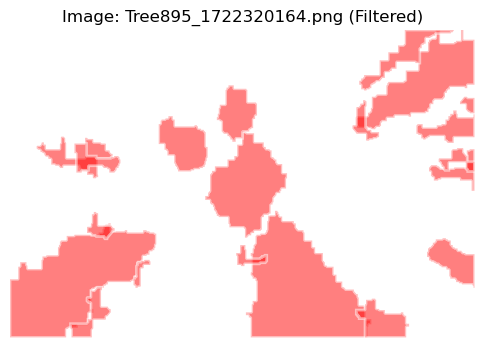

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from skimage.draw import polygon

with open('coco_files/birchforest/birchforest_coco.json', 'r') as f:
    coco_data = json.load(f)

images = {img['id']: img for img in coco_data['images']}
annotations = coco_data['annotations']

# Helper function: calculate the overlap ratio
def calculate_overlap_ratio(mask1, mask2, instance_area):
    intersection = np.logical_and(mask1, mask2).sum()
    return intersection / instance_area

for image_id, image_info in images.items():
    img_annotations = [ann for ann in annotations if ann['image_id'] == image_id]

    # Sort by area from largest to smallest
    img_annotations.sort(key=lambda x: x['area'], reverse=True)

    # Create background mask
    img_height, img_width = image_info['height'], image_info['width']
    background_mask = np.zeros((img_height, img_width), dtype=bool)

    filtered_annotations = []
    for ann in img_annotations:
        # Create binary mask for the current instance
        instance_mask = np.zeros((img_height, img_width), dtype=bool)
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly = np.array(seg).reshape(-1, 2)
            x, y = poly[:, 0], poly[:, 1]
            
            # Use skimage.draw.polygon to fill the polygon
            rr, cc = polygon(y, x, shape=(img_height, img_width))
            instance_mask[rr, cc] = True

        # Calculate overlap ratio
        overlap_ratio = calculate_overlap_ratio(instance_mask, background_mask, ann['area'])
        # print(f"Overlap ratio: {overlap_ratio}")
        if overlap_ratio > 0.5:
            continue

        # If it passes the check, add the instance to the retained list and update the background mask
        filtered_annotations.append(ann)
        background_mask = np.logical_or(background_mask, instance_mask)

    # Visualize the filtered results
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim(0, img_width)
    ax.set_ylim(0, img_height)
    ax.set_title(f"Image: {image_info['file_name']} (Filtered)")
    ax.set_axis_off()

    for ann in filtered_annotations:
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly = np.array(seg).reshape(-1, 2)
            patch = Polygon(poly, closed=True, facecolor='red', edgecolor='white', alpha=0.5, linewidth=2)
            ax.add_patch(patch)

    plt.gca().invert_yaxis()
    plt.show()
    
    break

### Filter Overlapped Instances

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from skimage.draw import polygon

coco_file_path = 'coco_files/citypark/citypark_coco.json'

# Load COCO file
with open(coco_file_path, 'r') as f:
    coco_data = json.load(f)

# Prepare data
images = {img['id']: img for img in coco_data['images']}
annotations = coco_data['annotations']

# Store filtered annotations and images
filtered_annotations = []
filtered_images = []

# Helper function: calculate the overlap ratio
def calculate_overlap_ratio(mask1, mask2, instance_area):
    intersection = np.logical_and(mask1, mask2).sum()
    return intersection / instance_area

# Process by image
for image_id, image_info in images.items():
    img_annotations = [ann for ann in annotations if ann['image_id'] == image_id]

    # Sort by area from largest to smallest
    img_annotations.sort(key=lambda x: x['area'], reverse=True)

    # Create background mask
    img_height, img_width = image_info['height'], image_info['width']
    background_mask = np.zeros((img_height, img_width), dtype=bool)

    filtered_image_annotations = []
    for ann in img_annotations:
        # Create binary mask for the current instance
        instance_mask = np.zeros((img_height, img_width), dtype=bool)
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly = np.array(seg).reshape(-1, 2)
            x, y = poly[:, 0], poly[:, 1]
            
            # Use skimage.draw.polygon to fill the polygon
            rr, cc = polygon(y, x, shape=(img_height, img_width))
            instance_mask[rr, cc] = True

        # Calculate overlap ratio
        overlap_ratio = calculate_overlap_ratio(instance_mask, background_mask, ann['area'])
        if overlap_ratio > 0.5:  # If the overlap ratio is greater than the threshold, skip
            continue

        # If it passes the check, add the instance to the retained list and update the background mask
        filtered_image_annotations.append(ann)
        background_mask = np.logical_or(background_mask, instance_mask)

    # Add image and its retained instances
    if filtered_image_annotations:
        filtered_annotations.extend(filtered_image_annotations)
        filtered_images.append(image_info)

# Save as a new COCO file
filtered_coco = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": coco_data["categories"]
}

# Save to file
save_path = coco_file_path.replace('.json', '_filtered.json')
with open(save_path, 'w') as f:
    json.dump(filtered_coco, f, separators=(',', ':'))

print("Filtered COCO file saved as 'filtered_coco.json'")

Filtered COCO file saved as 'filtered_coco.json'


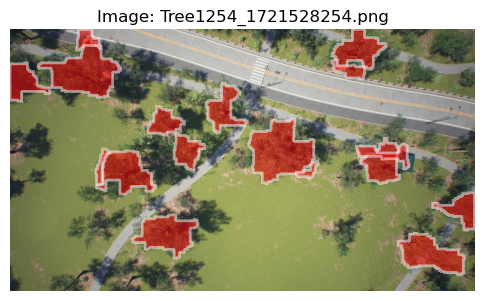

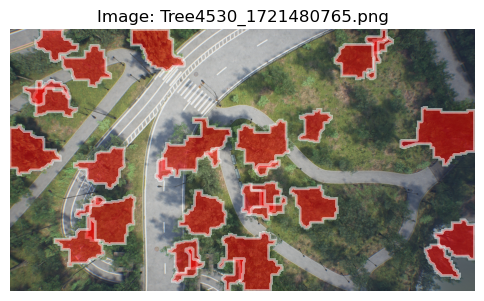

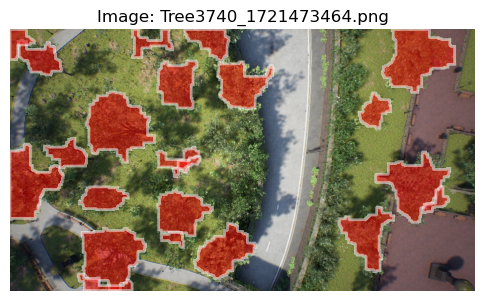

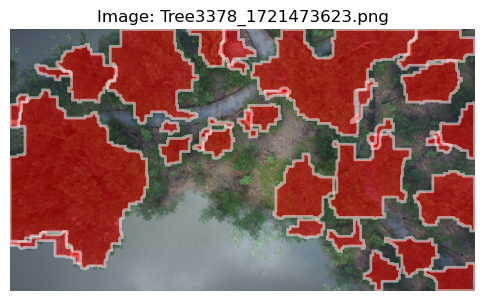

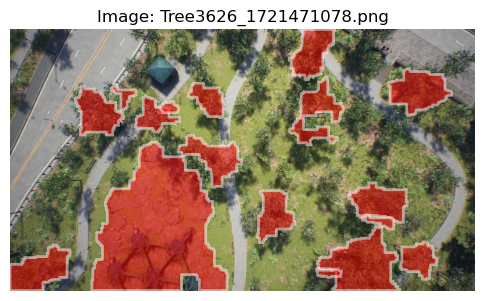

In [1]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import cv2  # Used to load images

# COCO file path
coco_file_path = 'detectree/coco_files/citypark/citypark_filtered.json'
# Get scene name
scene_name = coco_file_path.split('/')[-2]

# RGB image folder path
rgb_image_folder = 'detectree/data/SPREAD/raw/' + scene_name + '/rgb'

# Load COCO file
with open(coco_file_path, 'r') as f:
    coco_data = json.load(f)

# Prepare data
images = {img['id']: img for img in coco_data['images']}
annotations = coco_data['annotations']

# Display the first 5 images
current_image_id = 0

for image_id, image_info in images.items():
    img_file_name = image_info['file_name']
    img_file_path = os.path.join(rgb_image_folder, img_file_name)
    img_height, img_width = image_info['height'], image_info['width']
    
    # Load image file
    try:
        image = cv2.imread(img_file_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        else:
            print(f"Image file not found or unreadable: {img_file_path}")
            image = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255  # Create white background
    except Exception as e:
        print(f"Error loading image: {e}")
        image = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255  # Create white background
    
    # Set up plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(image)
    ax.set_xlim(0, img_width)
    ax.set_ylim(0, img_height)
    ax.set_title(f"Image: {img_file_name}")
    ax.set_axis_off()

    # Draw all instances belonging to this image
    for ann in annotations:
        if ann['image_id'] == image_id:
            segmentation = ann['segmentation']
            for seg in segmentation:
                poly = np.array(seg).reshape(-1, 2)
                patch = Polygon(poly, closed=True, facecolor='red', edgecolor='white', alpha=0.5, linewidth=2)
                ax.add_patch(patch)
    
    plt.gca().invert_yaxis()
    plt.show()
    
    current_image_id += 1
    if current_image_id >= 5:
        break

### Split into Train.json, Test.json, Val.json

In [6]:
import json
import random
import os

# Load COCO file
coco_file_path = "/detectree/coco_files/redwood/redwood_filtered.json"
# Get scene name
scene_name = coco_file_path.split('/')[-2]

with open(coco_file_path, 'r') as f:
    coco_data = json.load(f)

# Get all images and annotations
images = coco_data['images']
annotations = coco_data['annotations']

# Shuffle the image list to ensure randomness
random.seed(42)  # Ensure reproducibility
random.shuffle(images)

# Split images into 8:1:1 ratio
num_images = len(images)
train_split = int(0.8 * num_images)
val_split = int(0.2 * num_images)

train_images = images[:train_split]
val_images = images[train_split:train_split + val_split]
# test_images = images[train_split + val_split:]

# Filter annotations based on image groups
def filter_annotations(images_subset):
    image_ids = {img['id'] for img in images_subset}
    return [ann for ann in annotations if ann['image_id'] in image_ids]

train_annotations = filter_annotations(train_images)
val_annotations = filter_annotations(val_images)
# test_annotations = filter_annotations(test_images)

# Create COCO format data
def create_coco_dict(images_subset, annotations_subset):
    return {
        "images": images_subset,
        "annotations": annotations_subset,
        "categories": coco_data["categories"]  # Retain category information
    }

train_coco = create_coco_dict(train_images, train_annotations)
val_coco = create_coco_dict(val_images, val_annotations)
# test_coco = create_coco_dict(test_images, test_annotations)

# Save as JSON files
output_dir = os.path.dirname(coco_file_path)
with open(os.path.join(output_dir, "train.json"), 'w') as f:
    json.dump(train_coco, f)
with open(os.path.join(output_dir, "val.json"), 'w') as f:
    json.dump(val_coco, f)
# with open(os.path.join(output_dir, "test.json"), 'w') as f:
#     json.dump(test_coco, f)

print("Train, validation, and test sets have been saved as 'train.json', 'val.json'.")

Train, validation, and test sets have been saved as 'train.json', 'val.json'.
